In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import itertools
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import json
plt.style.use('bmh')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_json('recipe_train.json')
test = pd.read_json('recipe_test.json')

In [3]:
from collections import Counter

counters = {}
for cuisine in train['cuisine'].unique():
    counters[cuisine] = Counter()
    ind = (train['cuisine'] == cuisine)
    for i in train[ind]['ingredients']:
        counters[cuisine].update(i)

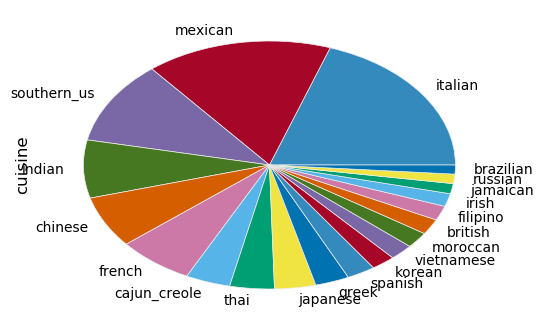

In [4]:
train['cuisine'].value_counts().plot(kind = 'pie')

In [5]:
counters['russian'].most_common(10)

[(u'salt', 288),
 (u'sugar', 155),
 (u'onions', 145),
 (u'all-purpose flour', 123),
 (u'sour cream', 117),
 (u'eggs', 112),
 (u'water', 111),
 (u'butter', 104),
 (u'unsalted butter', 93),
 (u'large eggs', 85)]

In [6]:
train['all'] = train['ingredients'].map(";".join)

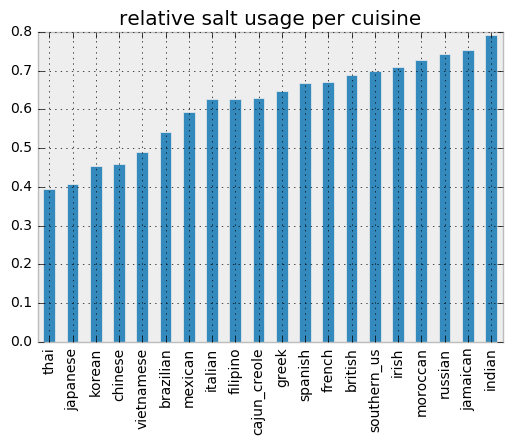

In [7]:
i = train['all'].str.contains('salt')
salt = (train[i]['cuisine'].value_counts() / train['cuisine'].value_counts())
salt.sort_values(inplace=True)
salt.plot(kind='bar',title='relative salt usage per cuisine')

In [8]:
ingredients_text = []
for i in train.ingredients:
    ingredients_text += [ing.lower() for ing in i]

In [9]:
len(ingredients_text)

428275

In [10]:
len(set(ingredients_text)) ##unique

6703

In [11]:
splitter = re.compile('[,. ]+')
words = []
for i in ingredients_text:
    words += re.split(splitter, i)

In [12]:
len(words)

807802

In [13]:
len(set(words))

3152

In [14]:
sorted(set(ingredients_text), key = len, reverse = True)[:10] ##\xea-type characters stand for speacial unicode characters

[u'pillsbury\xe2\u201e\xa2 crescent recipe creations\xe2\xae refrigerated seamless dough sheet',
 u'kraft mexican style shredded four cheese with a touch of philadelphia',
 u'bertolli vineyard premium collect marinara with burgundi wine sauc',
 u'hidden valley\xe2\xae original ranch salad\xe2\xae dressing & seasoning mix',
 u'hidden valley\xe2\xae farmhouse originals italian with herbs dressing',
 u'hellmann\xe3\xa2\xe2\u201a\xac\xe2\u201e\xa2 or best food canola cholesterol free mayonnais',
 u'kraft shredded pepper jack cheese with a touch of philadelphia',
 u'condensed reduced fat reduced sodium cream of mushroom soup',
 u'condensed reduced fat reduced sodium cream of chicken soup',
 u"i can't believ it' not butter! made with olive oil spread"]

In [15]:
def texttoing(text):
    return frozenset(re.split(re.compile('[,. ]+'), text))

In [16]:
all_ing = [texttoing(text) for text in ingredients_text]
#all_ing[:10]

In [17]:
def possibleing(ingredient):
    n = len(ingredient)
    possible = []
    for i in range(1, n + 1):
        possible += [frozenset(combi) for combi in itertools.combinations(ingredient, i)]
    return possible
#possibleing(texttoing("salt and vinegar with tomato"))

In [18]:
c = Counter(all_ing)
c.most_common(20)

[(frozenset({u'salt'}), 18049),
 (frozenset({u'oil', u'olive'}), 7972),
 (frozenset({u'onions'}), 7972),
 (frozenset({u'water'}), 7457),
 (frozenset({u'garlic'}), 7380),
 (frozenset({u'sugar'}), 6434),
 (frozenset({u'cloves', u'garlic'}), 6237),
 (frozenset({u'butter'}), 4848),
 (frozenset({u'black', u'ground', u'pepper'}), 4785),
 (frozenset({u'all-purpose', u'flour'}), 4632),
 (frozenset({u'pepper'}), 4438),
 (frozenset({u'oil', u'vegetable'}), 4385),
 (frozenset({u'eggs'}), 3388),
 (frozenset({u'sauce', u'soy'}), 3296),
 (frozenset({u'kosher', u'salt'}), 3113),
 (frozenset({u'green', u'onions'}), 3078),
 (frozenset({u'tomatoes'}), 3058),
 (frozenset({u'eggs', u'large'}), 2948),
 (frozenset({u'carrots'}), 2814),
 (frozenset({u'butter', u'unsalted'}), 2782)]

In [19]:
probability = defaultdict(lambda: 1, c.most_common())
#probability[texttoing('tomato sauce')]

In [20]:
def bestchoice(ingredient):
    return max(possibleing(ingredient), key=lambda c: probability[c])
#bestchoice(texttoing("salt and vinegar"))

In [21]:
pd.DataFrame([(text, 
               " ".join(bestchoice(texttoing(text)))) 
              for text in sorted(set(ingredients_text), key = len, reverse = True)[:10]],
            columns=['original choice', 'better choice'])

,original choice,better choice
0,pillsburyâ„¢ crescent recipe creationsâ® refri...,dough
1,kraft mexican style shredded four cheese with ...,cheese
2,bertolli vineyard premium collect marinara wit...,wine
3,hidden valleyâ® original ranch saladâ® dressin...,seasoning
4,hidden valleyâ® farmhouse originals italian wi...,herbs
5,hellmannã¢â‚¬â„¢ or best food canola cholester...,canola
6,kraft shredded pepper jack cheese with a touch...,pepper
7,condensed reduced fat reduced sodium cream of ...,cream
8,condensed reduced fat reduced sodium cream of ...,chicken
9,i can't believ it' not butter! made with olive...,olive oil


In [22]:
def candidates(ingredient, vocabulary):
    n = len(ingredient)
    for i in range(n - 1, 1, -1):
        possible = [frozenset(combi) for combi in itertools.combinations(ingredient, i) 
                    if frozenset(combi) in vocabulary]
        if len(possible) > 0:
            return possible
    return [ingredient]

In [23]:
vocabulary = dict(c.most_common())
list(vocabulary.keys())[:10]

[frozenset({u'cheddar', u'cheese', u'fat-free'}),
 frozenset({u'ammonium', u'bicarbonate'}),
 frozenset({u'jam', u'tomato'}),
 frozenset({u'beans', u'string'}),
 frozenset({u'chicken', u'cubes', u'stock'}),
 frozenset({u'komatsuna'}),
 frozenset({u'dressing', u'italian', u'robusto', u'wish-bone\xe2\xae'}),
 frozenset({u'eggs', u'large'}),
 frozenset({u'pork', u'side'}),
 frozenset({u'caviar', u'salmon'})]

In [24]:
candidates(texttoing('hidden valley original ranch spicy ranch dressing'), vocabulary)

[frozenset({'dressing', 'ranch'})]

In [25]:
def bestalternative(ingredient, vocabulary):
    return max(candidates(ingredient, vocabulary), key=lambda w: vocabulary[w])

In [26]:
pd.DataFrame([(text, 
               " ".join(bestalternative(texttoing(text), vocabulary))) 
              for text in sorted(set(ingredients_text), key=len, reverse=True)[:50]],
            columns=['original ingredient', 'improved ingredient'])

,original ingredient,improved ingredient
0,pillsburyâ„¢ crescent recipe creationsâ® refri...,dough seamless refrigerated crescent
1,kraft mexican style shredded four cheese with ...,cheese shredded
2,bertolli vineyard premium collect marinara wit...,sauc premium collect vineyard marinara bertoll...
3,hidden valleyâ® original ranch saladâ® dressin...,ranch dressing
4,hidden valleyâ® farmhouse originals italian wi...,herbs italian
5,hellmannã¢â‚¬â„¢ or best food canola cholester...,canola food free hellmannã¢â‚¬â„¢ mayonnais ch...
6,kraft shredded pepper jack cheese with a touch...,cheese pepper kraft jack shredded
7,condensed reduced fat reduced sodium cream of ...,mushroom sodium of fat soup reduced cream
8,condensed reduced fat reduced sodium cream of ...,condensed sodium of soup chicken reduced cream
9,i can't believ it' not butter! made with olive...,olive oil


In [27]:
len(ingredients_text)

428275

In [28]:
len(set(ingredients_text))

6703

In [29]:
train['all'] = train['ingredients'].map(";".join)

cv = CountVectorizer()
X = cv.fit_transform(train['all'].values)

le = LabelEncoder()
y = le.fit_transform(train.cuisine)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
def crossval(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

In [31]:
logistic = LogisticRegression()
crossval(logistic, X, y, 5)

[ 0.79145192  0.78881207  0.78252671  0.79044626  0.78124214]
Mean score: 0.787 (+/-0.002)


In [32]:
def deletenoise(text):
    return "".join([char for char in text.lower() if char.isalnum() or char.isspace()])

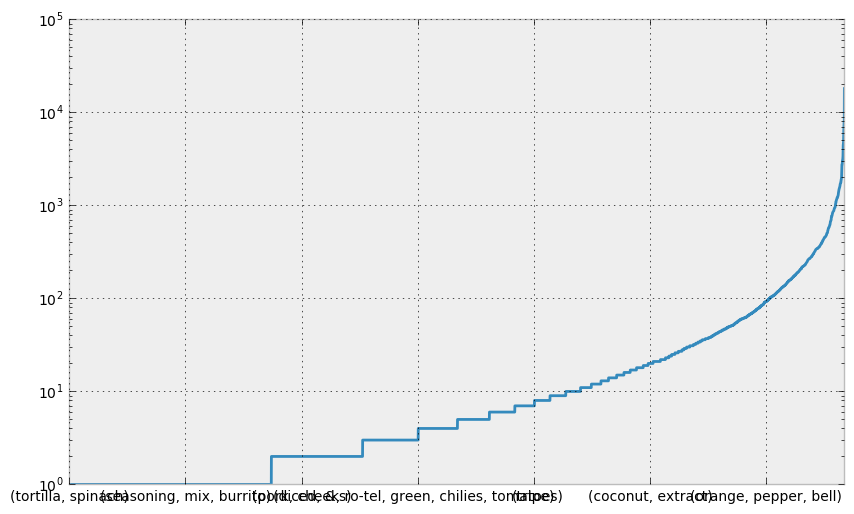

In [33]:
plt.figure(figsize=(10, 6))
pd.Series(vocabulary).sort_values().plot(logy=True)

In [34]:
def improving(ingredient_list):
    better_ingredients = []
    for ingredient in ingredient_list:
        cleaned_ingredient = deletenoise(ingredient)
        if vocabulary[texttoing(cleaned_ingredient)] <= 100:
            better_ingredients.append(" ".join(bestalternative(
                                        texttoing(cleaned_ingredient), vocabulary)))
        else:
            better_ingredients.append(cleaned_ingredient)
    return ";".join(better_ingredients)

In [35]:
ingr = []
for df in [train, test]:
    for ingredient_list in df.ingredients:
        ingr += [deletenoise(ing) for ing in ingredient_list]
all_ingredients = [texttoing(text) for text in ingr]
c = Counter(all_ingredients)
vocabulary = dict(c.most_common())

In [36]:
train['best_ingredients'] = train['ingredients'].map(improving)

In [37]:
X = cv.fit_transform(train['best_ingredients'].values)

In [38]:
crossval(logistic, X, y, 5)

[ 0.78818353  0.78680075  0.78214959  0.7893149   0.77910485]
Mean score: 0.785 (+/-0.002)


In [39]:
test['best_ingredients'] = test['ingredients'].map(improving)
X_test = cv.transform(test['best_ingredients'].values)

In [40]:
logistic.fit(X, y)
y_test = logistic.predict(X_test)

In [41]:
with open("test_words.csv", 'w') as f:
    f.write("id,cuisine\n")
    for i, cuisine in zip(test.id, le.inverse_transform(y_test)):
        f.write("{},{}\n".format(i, cuisine))

In [42]:
test_labels = pd.read_csv('test_words.csv')

In [43]:
test_labels.head()

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [44]:
test.head()

,id,ingredients,best_ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder;eggs;allpurpose flour;raisins;mi...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar;egg yolks;corn starch;cream of tartar;ba...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage links;fennel bulb;fronds;olive oil;pep...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cuts;powder file;smoked sausage;okra;shri...
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper;salt;sausage casings;leeks...


In [45]:
testdata = pd.merge(test, test_labels)
testdata.head()

,id,ingredients,best_ingredients,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder;eggs;allpurpose flour;raisins;mi...,british
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar;egg yolks;corn starch;cream of tartar;ba...,southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage links;fennel bulb;fronds;olive oil;pep...,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cuts;powder file;smoked sausage;okra;shri...,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper;salt;sausage casings;leeks...,italian


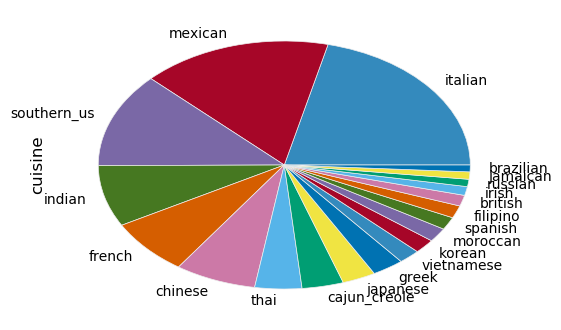

In [46]:
testdata['cuisine'].value_counts().plot(kind = 'pie')

In [47]:
counterstest = {}
for cuisine in testdata['cuisine'].unique():
    counterstest[cuisine] = Counter()
    ind = (testdata['cuisine'] == cuisine)
    for i in testdata[ind]['ingredients']:
        counterstest[cuisine].update(i)

In [48]:
counterstest['russian'].most_common(10)

[(u'salt', 57),
 (u'sour cream', 43),
 (u'onions', 36),
 (u'all-purpose flour', 26),
 (u'sugar', 24),
 (u'carrots', 24),
 (u'eggs', 23),
 (u'butter', 20),
 (u'beets', 20),
 (u'potatoes', 19)]

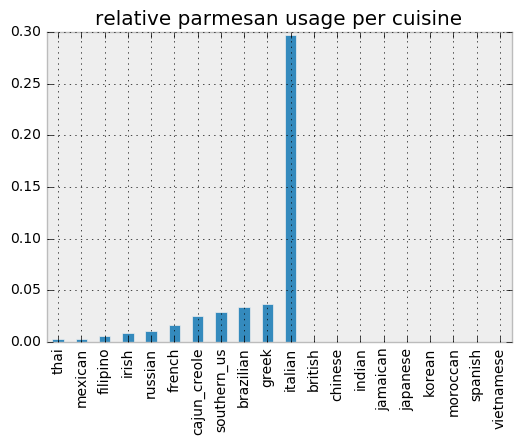

In [49]:
i = testdata['best_ingredients'].str.contains('parmesan')
salt = (testdata[i]['cuisine'].value_counts() / testdata['cuisine'].value_counts())
salt.sort_values(inplace=True)
salt.plot(kind='bar',title='relative parmesan usage per cuisine')
#seems legit

# Cuisine Similarity

In [50]:
#pca = PCA(n_components=5)

In [51]:
#reduced_data = pca.fit_transform(tfidfmatrix)

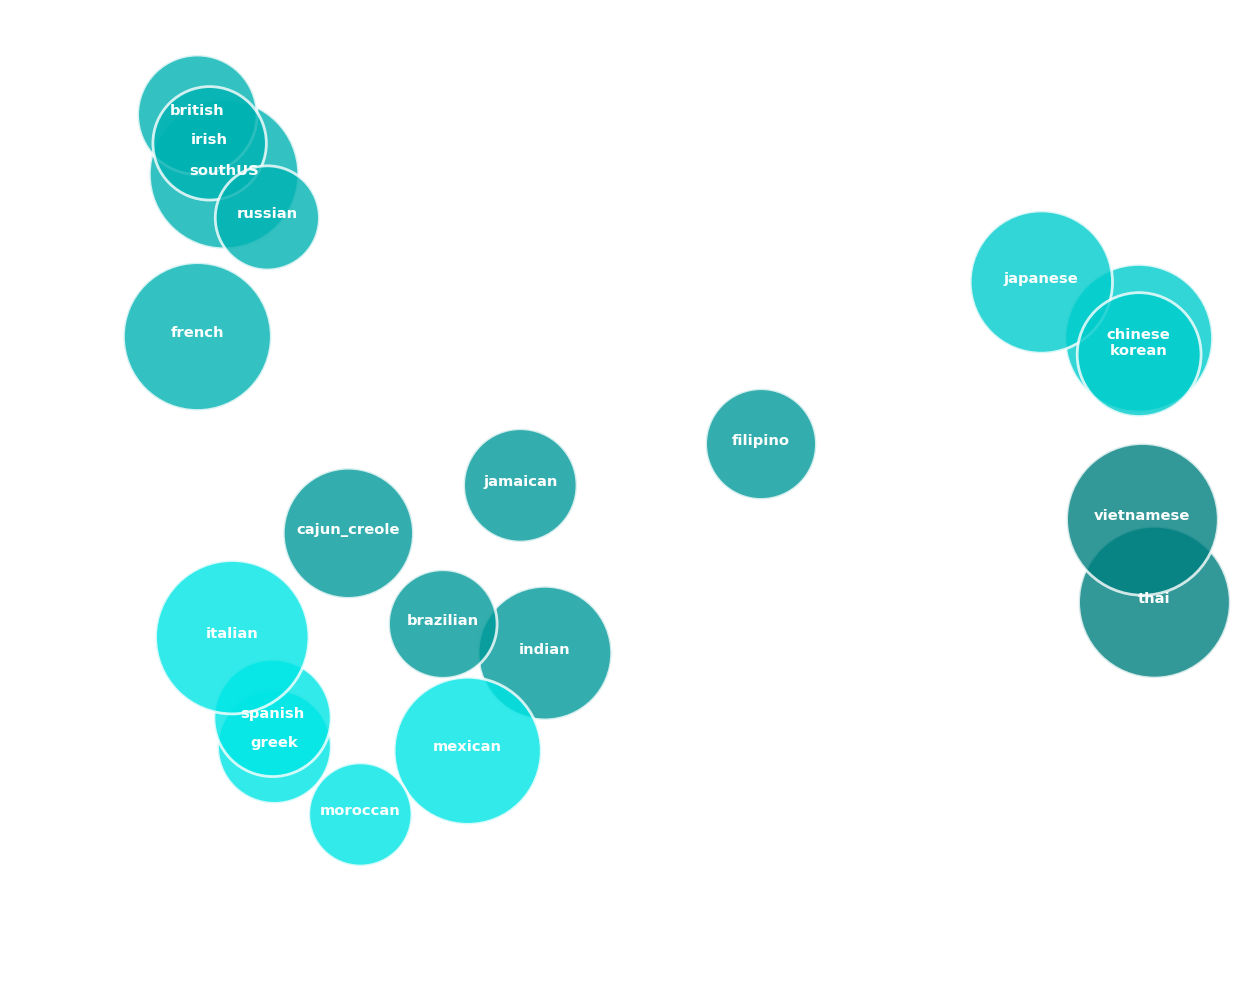

In [52]:
#part of this code is taken from a Kaggle discussion
with open('recipe_train.json') as data_file:    
    data = json.load(data_file)

def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
    
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) 
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) 
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)
            

import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) 
    tfidf.toarray() 
    return tfidf.toarray()

tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfIdf_Matrix)


pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(5)


i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: 
            if labels[j] == labels[i]: 
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []
colorPalette = [
'#00e5e5',
'#00cccc',
'#00b2b2',
'#009999',
'#007f7f',
'#006666',
'#004c4c',
'#003333',
'#001919'] 

plt.figure(1, figsize=figureRatios)
for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) 
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off')
plt.show()